In [1]:
import numpy as np

#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000

from scipy.interpolate import interpn
import math
import warnings
%matplotlib inline
import xarray as xr
#import bisect
import sklearn

warnings.filterwarnings('ignore')

# on the header:
import matplotlib as mpl
import math
import pandas as pd

In [2]:
import gsw

In [3]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')

In [4]:
# # make grid for density contours
# ax.set_xlim([34,34.7])
# # ax.set_ylim([-2.7,-1])

smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 35. + (0.01 * 35.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 20
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-3,3.3,ydim)
si = np.linspace(31,35,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens = dens - 1000
#print(np.max(dens),np.min(dens))

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 35.35


## For each index released at release times, is it within the TS limits

In [5]:
x = (ds.variables['Xgrid'].values)

In [6]:
# Gade line: WDW (Weddell Deep Water)
T_wdw = -2
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.990697896299028


In [7]:
Freez_temp = gsw.CT_freezing(si,0,0)

# Grab AABW indexes

In [8]:
with open("/scratch/project_2000789/muramarg/SOM/AABW_idxs.txt","r") as g:
    aabw_idx = g.read().splitlines() 
    aabw_idx = [int(x) for x in aabw_idx]
len(aabw_idx)

349

In [9]:
aabw_salt = ds.variables['salt'].values[:,aabw_idx]
aabw_temp = ds.variables['temp'].values[:,aabw_idx]
aabw_cmap = ds.variables['depth'].values[:,aabw_idx]

In [10]:
aabw_cmap = ds.variables['depth'].values[:,aabw_idx]

In [11]:
aabw_cmap*=-1

In [12]:
# get first values in the array
firstsalts = np.array([],dtype=np.int64)
for i in range(len(aabw_salt[0])):
    thiscol = aabw_salt[:,i]
    firstval = next(x for x in thiscol if not np.isnan(x))
    firstsalts = np.append(firstsalts,firstval)
firsttemps = np.array([],dtype=np.int64)
for i in range(len(aabw_temp[0])):
    thiscol = aabw_temp[:,i]
    firstval = next(x for x in thiscol if not np.isnan(x))
    firsttemps = np.append(firsttemps,firstval)
    
# get the last values in the array
lastsalts = aabw_salt[-1]
lasttemps = aabw_temp[-1]

## Find neutral density at all points in time

In [13]:
all_salt = ds.variables['salt'].values[:,aabw_idx]
all_temp = ds.variables['temp'].values[:,aabw_idx]

In [14]:
all_salt.shape

(65717, 349)

In [ ]:
#with open('/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_salt.txt', 'w') as f:
#     for row in all_salt:
#         row = ' '.join(map(str, row))
#         f.write(row)
#         f.write("\n")
# f.close()

In [ ]:
# with open('/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_temp.txt', 'w') as f:
#     for row in all_temp:
#         row = ' '.join(map(str, row))
#         f.write(row)
#         f.write("\n")
# f.close()

In [ ]:
# with open('/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_TS_nums.txt', 'w') as f:
#     for i,j in zip(all_salt,all_temp):
#         f.write(str(i)+"   "+str(j)+"   \n")
# f.close()

In [15]:
# read the file and add the density values from aabw_neutral_densities.txt
with open("/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_neutral_densities.txt","r") as g:
    lines = g.read().splitlines()
    #aabw_idx = [int(x) for x in aabw_idx]
#len(aabw_idx)
g.close()

In [16]:
linew = [x.strip() for x in lines]
all_nums = []
for i in linew:
    w = i.split()
    for x in w:
        if x != "[" and x != "]":
            if x[0] == "[":
                myx = x[1:]
            elif x[-1] == "]":
                myx = x[:-1]
            try:
                all_nums.append(float(myx))
            except:
                all_nums.append(np.nan)
print(len(all_nums))

22935233


In [17]:
arr = np.asarray(all_nums)
arr = np.reshape(arr,(65717,349))

## Create a dataframe with the values of interest for SOM

In [18]:
# Net length
# Total length
# Time
# Total length/net length
# T and S initial
# T and S final
# Depth (mean and stev)

In [19]:
# get an array of total lengths for lines in aabw_salt, aabw_temp
total_l = np.array([])
for i in range(len(aabw_salt[0])):
    thissalt = aabw_salt[:,i]
    thistemp = aabw_temp[:,i]
    # set the current distance
    dist = 0
    for j in range(len(thissalt)-1):
        if not math.isnan(thissalt[j]):
            p = [thissalt[j],thistemp[j]]
            q = [thissalt[j+1],thistemp[j+1]]
            dist += (math.dist(p,q))
    total_l = np.append(total_l,dist)

In [20]:
# get an array of the net lengths for aabw_salt,aabw_temp
net_l = np.array([])
for i in range(len(aabw_salt[0])):
    x1 = aabw_salt[:,i]
    x1 = x1[~np.isnan(x1)]
    x2 = x1[-1]
    x1 = x1[0]
    y1 = aabw_temp[:,i]
    y1 = y1[~np.isnan(y1)]
    y2 = y1[-1]
    y1 = y1[0]
    
    p = [x1,y1]
    q = [x2,y2]
    # set the current distance
    dist = (math.dist(p,q))
    net_l = np.append(net_l,dist)

In [21]:
# get arrays of the mean and stdev of depth
aabw_depth = ds.variables['depth'].values[:,aabw_idx]
depth_means = np.array([])
depth_std = np.array([])
for i in range(len(aabw_depth[0])):
    d = aabw_depth[:,i]
    d = d[~np.isnan(d)]
    meand = sum(d)/len(d)
    std_d = np.std(d)
    
    # append these to the list
    depth_means = np.append(depth_means,meand)
    depth_std = np.append(depth_std,std_d)

In [22]:
# get initial temperatures
t_init = np.array([])
s_init = np.array([])
t_final = np.array([])
s_final = np.array([])
for i in range(len(aabw_salt[0])):
    thissalt = aabw_salt[:,i]
    thistemp = aabw_temp[:,i]
    thissalt = thissalt[~np.isnan(thissalt)]
    thistemp = thistemp[~np.isnan(thistemp)]
    
    t_init = np.append(t_init,thistemp[0])
    s_init = np.append(s_init,thissalt[0])
    t_final = np.append(t_final,thistemp[-1])
    s_final = np.append(s_final,thissalt[-1])

In [23]:
# time to reach AABW
# arr is the neutral densities
    
# create an array with the first value in AABW
aabw_time = np.array([])
# for float in the floats
densi = 0
for idx in aabw_idx:
    # get the final point in the row
    thisrow_T = ds.variables['temp'].values[:,idx]
    thisrow_salt = ds.variables['salt'].values[:,idx]
    thisrow_depth = ds.variables['depth'].values[:,idx]
    # density is indexed differently because of how we've formatted it
    thisrow_dens = arr[:,densi]
  
    # zip the list to find first index with number, first index in AABW
    # get the start index
    current_idx = 0
    first = 0
    
    # find the first value that is not nan in the list
    timena = thisrow_T[~np.isnan(thisrow_T)]
    start_time = len(thisrow_T)-len(timena)

    # get first criteria that matches value, take greatest index of these
    resultT = np.where(thisrow_T <= 0)
    end_T = (resultT[0][0])
    results = np.where(thisrow_salt>34.4)
    end_s = (results[0][0])
    resultd = np.where(thisrow_depth < (-3500/3.281))
    end_d = (resultd[0][0])
    resultdens = np.where(thisrow_dens > 28.27)
    end_dens = (resultdens[0][0])
    
    # find the maximum value, this is the first instance of AABW
    endi = max(end_T,end_s,end_d,end_dens)
    aabw_time = np.append(aabw_time,endi-start_time)
    
    
    densi += 1
aabw_time = aabw_time*900/86400
#aabw_time

In [24]:
df = pd.DataFrame()
df["total distance"] = total_l
df["net distance"] = net_l
df["initial T"] = t_init
df["final T"] = t_final
df["initial salt"] = s_init
df["final salt"] = s_final
df["mean depth"] = depth_means
df["std depth"] = depth_std
df["time to aabw"] = aabw_time
df

,total distance,net distance,initial T,final T,initial salt,final salt,mean depth,std depth,time to aabw
0,7.239446,1.683358,-1.834889,-0.154201,34.560596,34.655376,-1380.633472,1121.455566,251.385417
1,10.158761,1.545949,-1.786091,-0.243271,34.547855,34.646164,-1336.957750,931.876587,178.812500
2,5.630729,1.446631,-1.740002,-0.296247,34.553970,34.645157,-2007.275123,1611.854492,225.406250
3,6.460529,1.536875,-1.808792,-0.274045,34.565708,34.646553,-2704.539751,1336.700073,81.250000
4,5.109327,1.591493,-1.874163,-0.288419,34.515099,34.650257,-3432.437147,1241.449463,53.812500
...,...,...,...,...,...,...,...,...,...
344,5.944698,1.580686,-1.880136,-0.299563,34.629169,34.648041,-2362.878106,1699.251465,162.885417
345,4.810220,1.643725,-1.884029,-0.240803,34.690914,34.650444,-2707.108203,995.262634,51.343750
346,7.634449,1.612078,-1.879212,-0.268103,34.590572,34.646469,-1401.438010,1208.631592,214.197917
347,4.073718,1.547423,-1.883183,-0.336334,34.684097,34.641941,-2535.859073,1578.445312,137.197917


## Define the functions for SOM

In [25]:
x = df.iloc[:,:].values
#y = df.iloc[:,-1].values
import sklearn
#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc = sklearn.preprocessing.MinMaxScaler(feature_range = (0,1))
x = sc.fit_transform(x)

In [26]:
from minisom import MiniSom

In [27]:
som = MiniSom(x=2,y=2,input_len=9,sigma=1.0,learning_rate=0.5)
som.random_weights_init(x)
som.train_random(data=x,num_iteration=100)

(349,)


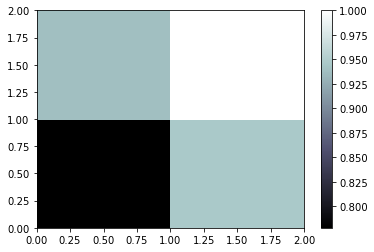

In [28]:
from pylab import bone,pcolor,colorbar,plot,show
bone()
pcolor(som.distance_map().T)
colorbar()

# make an array for the groupings
groupings = np.empty((0,2))
for i,a in enumerate(x):
    w = som.winner(a)
    groupings = np.append(groupings,np.array([w]),axis=0)
#print(groupings)

# remake the groupings into numbers
gr_idx = np.array([])
for l in groupings:
    if l[0] == 0:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,0)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,1)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,2)
    elif l[0] == 1:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,3)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,4)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,5)
    elif l[0] == 2:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,6)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,7)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,8)
print(gr_idx.shape)

## Create a TS diagram colored based on the categories

In [29]:
aabw_cmap = np.tile(gr_idx,(65717,1))
aabw_cmap.shape
aabw_cmap

array([[4., 0., 1., ..., 3., 4., 4.],
       [4., 0., 1., ..., 3., 4., 4.],
       [4., 0., 1., ..., 3., 4., 4.],
       ...,
       [4., 0., 1., ..., 3., 4., 4.],
       [4., 0., 1., ..., 3., 4., 4.],
       [4., 0., 1., ..., 3., 4., 4.]])

In [30]:
set(gr_idx)

{0.0, 1.0, 3.0, 4.0}

In [35]:
# plot floats ending as AASW colored by time
figure = plt.figure(figsize=[25, 25])
ax = plt.subplot(1,1,1)
plt.title('AABW')
plt.rcParams['axes.labelsize']='x-large'
plt.scatter(aabw_salt,aabw_temp,s=0.1,marker='o',c=aabw_cmap,cmap='viridis')
plt.scatter(firstsalts,firsttemps,marker='X',color='g',label="Starting points")
plt.scatter(lastsalts,lasttemps,marker='X',color='r',label="Endpoints")
#cbar = plt.colorbar(ticks=[0, 2820, 5640, 8460, 11280, 14100, 16920, 19740, 22560])
#cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0','30','60','90','120','150','180','210','240'])
#cbar.set_label('Depth', rotation=270,labelpad=15)
plt.plot(si,Freez_temp,'-',color='dimgray',label='Seawater Freezing',alpha=0.5,zorder=1)
#plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=2)
plt.ylim([-2.4,0.3])
plt.xlim([33.8,35.1])
plt.legend(loc="best",fontsize="x-large")
cs = ax.contour(si, ti, dens, colors="silver", zorder=1,alpha=0.5)
#ax.contour(si,ti,Freez_temp, colors="grey", zorder=1,alpha=0.5)
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")

plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_922/aabw_grouped.png", dpi=300)
plt.close()

In [32]:
# break down the aabw_salt and aabw_temp by the indices of the groups
group0 = np.where(gr_idx == 0)
group1 = np.where(gr_idx == 1)
group2 = np.where(gr_idx == 3)
group3 = np.where(gr_idx == 4)

# group hte aabw_salt and aabw_temp by these indices
aabw_salt0 = aabw_salt[:,group0]
aabw_salt1 = aabw_salt[:,group1]
aabw_salt2 = aabw_salt[:,group2]
aabw_salt3 = aabw_salt[:,group3]

aabw_temp0 = aabw_temp[:,group0]
aabw_temp1 = aabw_temp[:,group1]
aabw_temp2 = aabw_temp[:,group2]
aabw_temp3 = aabw_temp[:,group3]

In [43]:
# plot floats ending as AASW colored by time
fig = plt.figure(figsize=[25, 25])
ax = fig.add_subplot(2, 2, 1)
plt.scatter(aabw_salt0,aabw_temp0,s=0.1,marker='o',color="red")
plt.title("Group I")
plt.plot(si,Freez_temp,'-',color='dimgray',label='Seawater Freezing',alpha=0.5,zorder=1)
plt.ylim([-2.4,0.3])
plt.xlim([33.8,35.1])
cs = ax.contour(si, ti, dens, colors="silver", zorder=1,alpha=0.5)

ax = fig.add_subplot(2, 2, 2)
plt.title("Group II")
plt.scatter(aabw_salt1,aabw_temp1,s=0.1,marker='o',color="orange")
plt.plot(si,Freez_temp,'-',color='dimgray',label='Seawater Freezing',alpha=0.5,zorder=1)
plt.ylim([-2.4,0.3])
plt.xlim([33.8,35.1])
cs = ax.contour(si, ti, dens, colors="silver", zorder=1,alpha=0.5)

ax = fig.add_subplot(2, 2, 3)
plt.title("Group III")
plt.scatter(aabw_salt2,aabw_temp2,s=0.1,marker='o',color="purple")
plt.plot(si,Freez_temp,'-',color='dimgray',label='Seawater Freezing',alpha=0.5,zorder=1)
plt.ylim([-2.4,0.3])
plt.xlim([33.8,35.1])
cs = ax.contour(si, ti, dens, colors="silver", zorder=1,alpha=0.5)

ax = fig.add_subplot(2, 2, 4)
plt.title("Group IV")
plt.scatter(aabw_salt3,aabw_temp3,s=0.1,marker='o',color="blue")
plt.plot(si,Freez_temp,'-',color='dimgray',label='Seawater Freezing',alpha=0.5,zorder=1)
plt.ylim([-2.4,0.3])
plt.xlim([33.8,35.1])
cs = ax.contour(si, ti, dens, colors="silver", zorder=1,alpha=0.5)
plt.rcParams['axes.labelsize']='x-large'


plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_922/2by2_aabw_groups.png", dpi=300)
plt.close()

### Find average pathways based on the categorizations in the color index

In [36]:
#gr_idx.shape
group0 = np.where(gr_idx == 0)[0]
group1 = np.where(gr_idx == 1)[0]
group2 = np.where(gr_idx == 3)[0]
group3 = np.where(gr_idx == 4)[0]

group0n = np.array([],dtype=int)
for i in group0:
    group0n = np.append(group0n,int(aabw_idx[i]))
group1n = np.array([],dtype=int)
for i in group1:
    group1n = np.append(group1n,int(aabw_idx[i]))
group2n = np.array([],dtype=int)
for i in group2:
    group2n = np.append(group2n,int(aabw_idx[i]))
group3n = np.array([],dtype=int)
for i in group3:
    group3n = np.append(group3n,int(aabw_idx[i]))

In [37]:
# find the average location pathway for each group
group0x = ds.variables['Xgrid'][:,group0n]
group1x = ds.variables['Xgrid'][:,group1n]
group2x = ds.variables['Xgrid'][:,group2n]
group3x = ds.variables['Xgrid'][:,group3n]

group0y = ds.variables['Ygrid'][:,group0n]
group1y = ds.variables['Ygrid'][:,group1n]
group2y = ds.variables['Ygrid'][:,group2n]
group3y = ds.variables['Ygrid'][:,group3n]

In [38]:
# plot these on the grid

In [57]:
# find the average of these and make into lat/long values
g0x_avg = np.nanmean(group0x,axis=1)
g1x_avg = np.nanmean(group1x,axis=1)
g2x_avg = np.nanmean(group2x,axis=1)
g3x_avg = np.nanmean(group3x,axis=1)

g0y_avg = np.nanmean(group0y,axis=1)
g1y_avg = np.nanmean(group1y,axis=1)
g2y_avg = np.nanmean(group2y,axis=1)
g3y_avg = np.nanmean(group3y,axis=1)

In [58]:
g0x_avg

array([      nan,       nan,       nan, ..., 476.99426, 476.99414,
       476.99393], dtype=float32)

In [59]:
group0x[-1]

<xarray.Variable (drifter: 35)>
array([501.9419 , 463.60944, 453.28647, 462.06436, 528.3292 , 475.25372,
       487.49496, 451.536  , 530.72925, 488.11105, 447.8891 , 526.8369 ,
       524.5593 , 478.16306, 443.70657, 445.81244, 523.5303 , 440.84344,
       479.32266, 446.76202, 492.74945, 447.31305, 472.79153, 482.57785,
       456.575  , 526.5035 , 477.63492, 481.6306 , 444.08594, 444.4904 ,
       460.18793, 461.89322, 475.303  , 466.8581 , 504.40936], dtype=float32)
Attributes:
    long_name:  x-grid floats locations
    valid_min:  0.0
    valid_max:  629.0
    time:       ocean_time
    field:      Xgrid, scalar, series

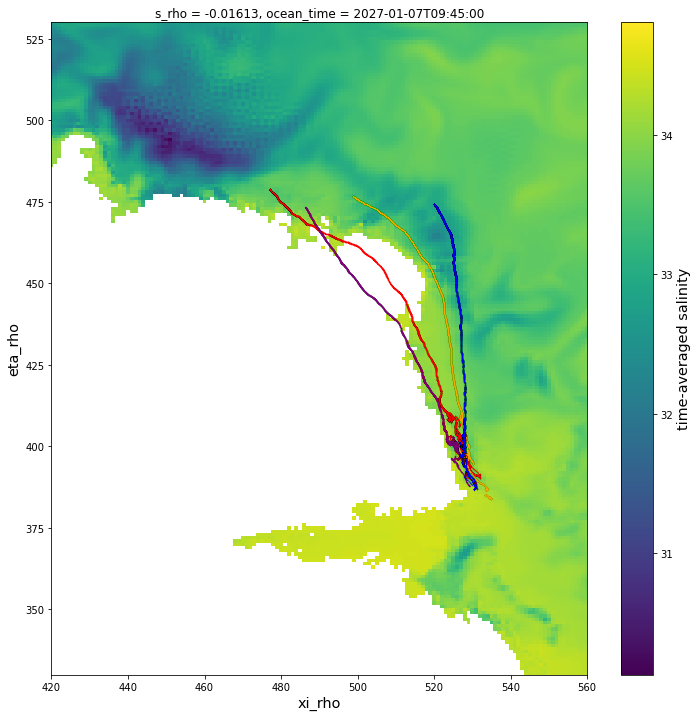

In [60]:
# write the arrays to a text file to find lat/long values
fig = plt.figure(figsize=(12,12))
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(g0x_avg,g0y_avg,marker='.',s=0.1,color='red',alpha=0.2)
plt.scatter(g1x_avg,g1y_avg,marker='.',s=0.1,color='orange',alpha=0.2)
plt.scatter(g2x_avg,g2y_avg,marker='.',s=0.1,color='purple',alpha=0.2)
plt.scatter(g3x_avg,g3y_avg,marker='.',s=0.1,color='blue',alpha=0.2)
plt.show()

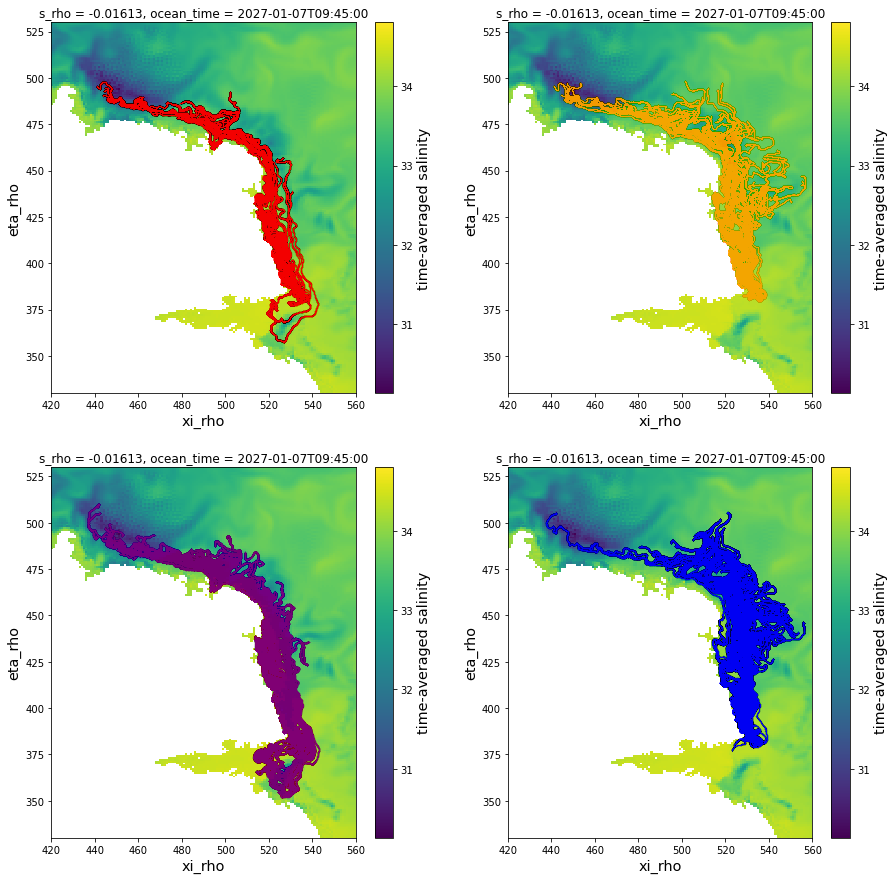

In [44]:
# THESE ARE IN GRID POINTS not spherical
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group0x,group0y,marker='.',s=0.1,color='red',alpha=0.2)

ax = fig.add_subplot(2, 2, 2)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group1x,group1y,marker='.',s=0.1,color='orange',alpha=0.2)

ax = fig.add_subplot(2, 2, 3)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group2x,group2y,marker='.',s=0.1,color='purple',alpha=0.2)

ax = fig.add_subplot(2, 2, 4)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group3x,group3y,marker='.',s=0.1,color='blue',alpha=0.2)

plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_922/2by2_mapped_aabw.png", dpi=300)

### Create the four groups of temperature plots colored by depth

In [62]:
depth = ds.variables['depth'].values[:,aabw_idx]
temp = ds.variables['temp'].values[:,aabw_idx]

time = temp.shape[0]
time = np.arange(0,time,1)
x_time = np.tile(time,(349,1))
x_time = x_time.T   # this will be our time matrix to color the numbers
x_time = x_time*900/86400

# mark the first values in each column
first_depths = np.array([])
first_times = np.array([])
a = depth[:,0]
b = a[~np.isnan(a)]

for idx in (range(depth.shape[1])):
    a = depth[:,idx]
    b = a[~np.isnan(a)]
    first_depths = np.append(first_depths,b[0])
    first_times = np.append(first_times,(len(a)-len(b))*900/86400)

In [72]:
# separate the depth values by group
depth0 = ds.variables["depth"].values[:,group0n]
depth1 = ds.variables["depth"].values[:,group1n]
depth2 = ds.variables["depth"].values[:,group2n]
depth3 = ds.variables["depth"].values[:,group3n]

temp0 = ds.variables['temp'].values[:,group0n]
temp1 = ds.variables['temp'].values[:,group1n]
temp2 = ds.variables['temp'].values[:,group2n]
temp3 = ds.variables['temp'].values[:,group3n]


time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth0.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400

x_time1 = np.tile(time,(depth1.shape[1],1))
x_time1 = x_time1.T   # this will be our time matrix to color the numbers
x_time1 = x_time1*900/86400

x_time2 = np.tile(time,(depth2.shape[1],1))
x_time2 = x_time2.T   # this will be our time matrix to color the numbers
x_time2 = x_time2*900/86400

x_time3 = np.tile(time,(depth3.shape[1],1))
x_time3 = x_time3.T   # this will be our time matrix to color the numbers
x_time3 = x_time3*900/86400

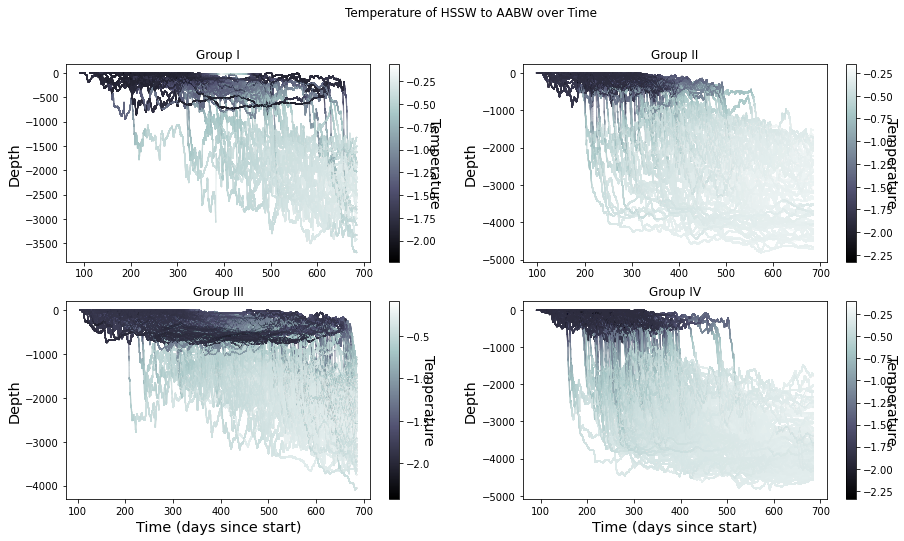

In [77]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(15,8))
fig.tight_layout(pad=5.0)
plt.suptitle("Temperature of HSSW to AABW over Time")
ax = fig.add_subplot(2, 2, 1)
plt.scatter(x_time0,depth0,marker=".",s=0.05,c=temp0)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group I")
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 2)
plt.scatter(x_time1,depth1,marker=".",s=0.05,c=temp1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group II")
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 3)
plt.scatter(x_time2,depth2,marker=".",s=0.05,c=temp2)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group III")
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 4)
plt.scatter(x_time3,depth3,marker=".",s=0.05,c=temp3)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group IV")
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

#plt.show()
plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_922/T_over_time.png", dpi=300)

In [78]:
dTdt = np.diff(temp0,axis=0)
dTdt0 = dTdt/(900/86400)
x_new0 = x_time0[1:]
depth_new0 = depth0[1:]

dTdt = np.diff(temp1,axis=0)
dTdt1 = dTdt/(900/86400)
x_new1 = x_time1[1:]
depth_new1 = depth1[1:]

dTdt = np.diff(temp2,axis=0)
dTdt2 = dTdt/(900/86400)
x_new2 = x_time2[1:]
depth_new2 = depth2[1:]

dTdt = np.diff(temp3,axis=0)
dTdt3 = dTdt/(900/86400)
x_new3 = x_time3[1:]
depth_new3 = depth3[1:]

In [80]:
temp0.shape

(65717, 35)

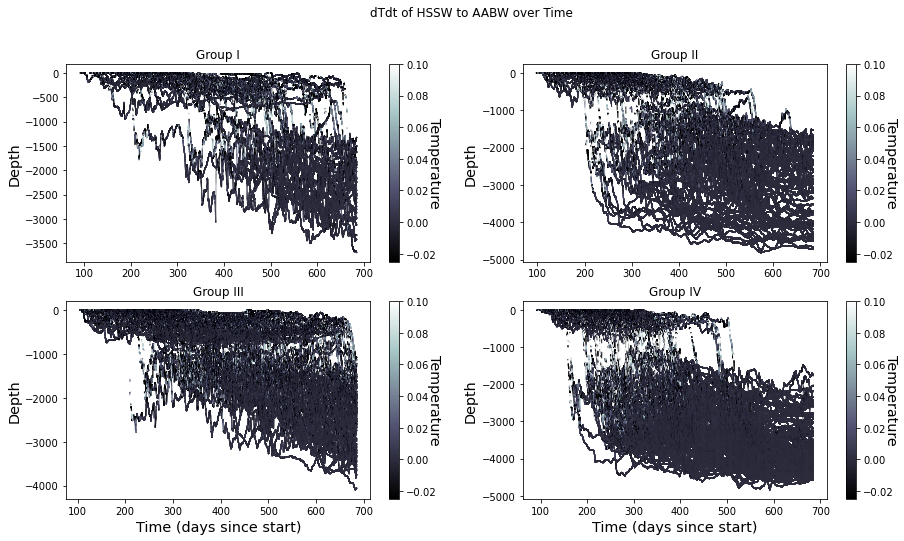

In [83]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(15,8))
fig.tight_layout(pad=5.0)
plt.suptitle("dTdt of HSSW to AABW over Time")
ax = fig.add_subplot(2, 2, 1)
plt.scatter(x_new0,depth_new0,marker=".",s=0.05,c=dTdt0,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group I")
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 2)
plt.scatter(x_new1,depth_new1,marker=".",s=0.05,c=dTdt1,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group II")
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 3)
plt.scatter(x_new2,depth_new2,marker=".",s=0.05,c=dTdt2,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group III")
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 4)
plt.scatter(x_new3,depth_new3,marker=".",s=0.05,c=dTdt3,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group IV")
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

#plt.show()
plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_922/dTdt_over_time.png", dpi=300)

### Create a density and residence time map of just the AABW

In [ ]:
alist = [line.rstrip() for line in open('aabw_idxs.txt')]
aabw_idx = np.array([])
for line in alist:
    thisline = line.split()
    for i in thisline:
        aabw_idx = np.append(aabw_idx,int(i))
aabw_idx = aabw_idx.astype(int)

In [ ]:
import time

In [ ]:
x = (ds.variables['Xgrid'].values[:,aabw_idx])
y = (ds.variables['Ygrid'].values[:,aabw_idx])
print(x.shape)
#depth = (ds.variables['depth'][-1].values)

# divide the normal grid by 10
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]
print(xbins.shape,ybins.shape)

# index of bins the particles ending in
x_new = np.digitize(x,xbins)
y_new = np.digitize(y,ybins)

print(x_new)

m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
        
    m2.append(newl)
    
# each bin has an average or total time that any one particle spends in it

# for each column\
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(1000):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)
#print(m2)

In [ ]:
# AVERAGE MESH
mesh = np.zeros((len(xbins),len(ybins)))

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                mesh[ii][jj] = avg
            else:
                print(avg)

# MAX MESH
mesh_max = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = max(m2[ii][jj])
            #print(avg)
            mesh_max[ii][jj] = avg
            #else:
            #    print(avg)
# MIN MESH
mesh_min = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = min(m2[ii][jj])
            if avg<200:
                mesh_min[ii][jj] = avg
            #else:
            #    print(avg)

# STDEV MESH
mesh_std = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = np.std(m2[ii][jj])
            #if avg<200:
            mesh_std[ii][jj] = avg
            
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

In [ ]:
# write the mesh to a text file
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

In [ ]:
# average values
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=50)
plt.colorbar()
plt.title("Average Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# maximum values
ax = fig.add_subplot(2, 2, 2, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_max[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=200)
plt.colorbar()
plt.title("Maximum Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# minimum values
ax = fig.add_subplot(2, 2, 3, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_min[300:,250:],transform=ccrs.PlateCarree(),zorder=2)
plt.colorbar()
plt.title("Minimum Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# standard deviation
ax = fig.add_subplot(2, 2, 4, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_std[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=40)
plt.colorbar()
plt.title("Standard Deviation of Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

plt.savefig('/scratch/project_2000789/muramarg/SOM/meeting_922/aabw_restime.png')



#myds = ds1.temp[xlimit,ylimit]
#ds1.h.isel(xi_rho=slice(350, 630),eta_rho=slice(300,630)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())